In [2]:
import gc
import pickle
import cfgrib
import pygrib

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

from glob import glob
from functools import reduce
from datetime import datetime
from sklearn.preprocessing import RobustScaler

use_era_scaler = False

In [3]:
model = 'gfs0p25'
archive = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/archive/'
mlmodel_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/output/slr_models/all_dev/'

In [4]:
init = datetime(2020, 1, 1, 0, 0)
date_fmt = '%Y%m%d'
datetime_fmt = '%Y%m%d%H'

## Data Ingest

In [5]:
flist = glob(archive + init.strftime(date_fmt) + '/models/%s/*%s*.grib2'%(model, init.strftime(datetime_fmt)))

datasets = cfgrib.open_datasets(flist[1])

train_keys = ['tp', 'q', 't', 'u', 'v', 'absv', 'w', 'gh', 'r', 'd', 
              'u10', 'v10', 'u100', 'v100', 't2m', 'd2m', 
              'cape', 'prmsl', 'sp', 'orog', 'hpbl']

derived = ['day_of_year', 'spd', 'dir']

sfc, iso, hAG = [], [], []

for ds in datasets:
    
    key_match = np.array(list(ds.data_vars))[np.isin(list(ds.data_vars), train_keys)]
    
    if len(key_match) > 0:
        
        dims = ds.dims.keys()
        coords = ds[key_match].coords
    
        if ('heightAboveGround' in coords) & ('heightAboveGround' not in dims):
            sfc.append(ds[key_match].drop('heightAboveGround'))
            
        elif 'isobaricInhPa' in coords:
            iso.append(ds[key_match])

        elif (('surface' in coords)|('meanSea' in coords)):
            sfc.append(ds[key_match])
        
        elif 'prmsl' in list(ds.data_vars):
            sfc.append(ds['prmsl'])
            
        else:
            pass
        
    else:
        pass
        #print(list(ds.data_vars))
        
sfc = xr.merge(sfc).drop('t')
iso = xr.merge(iso).rename({'isobaricInhPa':'level'})
iso = iso.sel(level=iso.level[::-1])

sfc['longitude'] = sfc['longitude'] - 360
iso['longitude'] = iso['longitude'] - 360

In [6]:
u, v = iso['u'], iso['v']
wdir = 90 - np.degrees(np.arctan2(-v, -u))
wdir = xr.where(wdir <= 0, wdir+360, wdir)
wdir = xr.where(((u == 0) & (v == 0)), 0, wdir)

iso['dir'] = wdir
iso['spd'] = np.sqrt(u**2 + v**2)

for hgt in [10, 100]:
    
    u, v = sfc['u%d'%hgt], sfc['v%d'%hgt]
    wdir = 90 - np.degrees(np.arctan2(-v, -u))
    wdir = xr.where(wdir <= 0, wdir+360, wdir)
    wdir = xr.where(((u == 0) & (v == 0)), 0, wdir)
    
    sfc['dir%dm'%hgt] = wdir
    sfc['spd%dm'%hgt] = np.sqrt(u**2 + v**2)

In [7]:
# sfc['day_of_year'] = (('latitude', 'longitude'), 
#                       np.full(sfc.orog.shape, 
#                               fill_value=pd.to_datetime(
#                                   sfc.time.values).strftime('%j')).astype(int))
# sfc

## Transform to levels above ground

In [8]:
orog = sfc.orog
gh = iso.gh

lowest_level = np.full(orog.shape, fill_value=np.nan)
lowest_level_index = np.full(orog.shape, fill_value=np.nan)

for i, level in enumerate(iso['level']):
    
    lev_gh = gh.sel(level=level)
    lowest_level = xr.where(orog >= lev_gh, level.values, lowest_level)
    lowest_level_index = xr.where(orog >= lev_gh, i, lowest_level_index)
    
lowest_level_index = xr.where(np.isnan(lowest_level), 0, lowest_level_index)
lowest_level = xr.where(np.isnan(lowest_level), 1000, lowest_level)

In [9]:
df = []
match_rename = {'absv':'vo', 'gh':'z', 'hpbl':'blh', 'prmsl':'msl', 'tp':'swe_mm',
               'u10':'u10m', 'v10':'v10m', 'u100':'u100m', 'v100':'v100m'}

# Loop over each variable in the xarray
for ds in [iso, sfc.drop('orog')]:
    
    for var_name in ds.data_vars:
        
        new_var_name = match_rename[var_name] if var_name in match_rename.keys() else var_name
        print('Reducing (%s) to %s index level AGL'%(var_name, new_var_name))

        var = ds[var_name]

        if 'level' in var.coords:

            for i in np.arange(10):

                var_agl = np.full(shape=(orog.shape), fill_value=np.nan)

                for j, level in enumerate(iso['level']):

                    var_agl = xr.where(lowest_level_index+i == j, var.isel(level=j), var_agl)

                    # Record the levels used, should match lowest_level array, sanity check
                    # var_agl[i, :, :] = xr.where(lowest_level_index+i == j, level, var_agl[i, :, :])

                # We could ho ahead and append to the pandas dataframe here 
                # at the completion of each level (_01agl, _02agl...)
                # We will have to use [(time), lat, lon] as a multiindex
                var_agl = xr.DataArray(var_agl, 
                     dims=['latitude', 'longitude'], 
                     coords={'latitude':iso['latitude'], 
                             'longitude':iso['longitude']})

                df.append(var_agl.to_dataframe(name='%s_%02dagl'%(new_var_name.upper(), i+1)))

                del var_agl
                gc.collect()

        else:

            var_agl = xr.DataArray(var.values, 
                dims=['latitude', 'longitude'], 
                coords={'latitude':iso['latitude'], 
                     'longitude':iso['longitude']})

            df.append(var_agl.to_dataframe(name='%s'%new_var_name.upper()))
            
df = reduce(lambda left, right: pd.merge(left, right, on=['latitude', 'longitude']), df)
df = df.rename(columns={'SWE_MM':'swe_mm'})

Reducing (t) to t index level AGL
Reducing (gh) to z index level AGL
Reducing (u) to u index level AGL
Reducing (v) to v index level AGL
Reducing (r) to r index level AGL
Reducing (w) to w index level AGL
Reducing (absv) to vo index level AGL
Reducing (dir) to dir index level AGL
Reducing (spd) to spd index level AGL
Reducing (u10) to u10m index level AGL
Reducing (v10) to v10m index level AGL
Reducing (t2m) to t2m index level AGL
Reducing (d2m) to d2m index level AGL
Reducing (u100) to u100m index level AGL
Reducing (v100) to v100m index level AGL
Reducing (prmsl) to msl index level AGL
Reducing (cape) to cape index level AGL
Reducing (sp) to sp index level AGL
Reducing (tp) to swe_mm index level AGL
Reducing (hpbl) to blh index level AGL
Reducing (dir10m) to dir10m index level AGL
Reducing (spd10m) to spd10m index level AGL
Reducing (dir100m) to dir100m index level AGL
Reducing (spd100m) to spd100m index level AGL


In [19]:
scaler_file = glob(mlmodel_dir + '*scaler*')[-1]
stats_file = glob(mlmodel_dir + '*train_stats*')[-1]
model_file = glob(mlmodel_dir + '*SLRmodel*')[-1]

if use_era_scaler == True:
    with open(scaler_file, 'rb') as rfp:
        scaler = pickle.load(rfp)
else:
    scaler = RobustScaler(quantile_range=(25, 75))

with open(stats_file, 'rb') as rfp:
    train_stats, train_stats_norm = pickle.load(rfp)
    model_keys = train_stats.keys()
    
with open(model_file, 'rb') as rfp:
    SLRmodel = pickle.load(rfp)

In [20]:
print('\ncheck: missing from model', [k for k in df.keys() if k not in model_keys])
print('\ncheck: missing from input', [k for k in model_keys if k not in df.keys()])
print()

df = df.loc[:, model_keys]
scaler = scaler.fit(df)


check: missing from model []

check: missing from input []



In [21]:
df_norm = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.keys())
df_norm

swe_mm   T_01agl   U_01agl   V_01agl  VO_01agl   W_01agl  \
latitude longitude                                                             
30.0     -130.00       0.0  0.737365 -1.669108 -2.335532 -0.233847 -0.203804   
         -129.75       0.0  0.737365 -1.610452 -2.359377 -0.190000 -0.180957   
         -129.50       0.0  0.728999 -1.555707 -2.377261 -0.175385 -0.231219   
         -129.25       0.0  0.720636 -1.512692 -2.405081 -0.204616 -0.107850   
         -129.00       0.0  0.720636 -1.457947 -2.468669 -0.190000 -0.085004   
...                    ...       ...       ...       ...       ...       ...   
50.0     -101.00       0.0 -0.864033  0.350756 -0.060728  0.985384  0.011610   
         -100.75       0.0 -0.939317  0.329249  0.092280  0.722307 -0.509281   
         -100.50       0.0 -1.014602  0.370308  0.153880  0.444614 -0.573250   
         -100.25       0.0 -1.064793  0.471977  0.118112  0.327691 -0.650927   
         -100.00       0.0 -1.064793  0.685093  0.084331  0.137690 -0.285389   

                     Z_01agl   R_01agl  SPD_01agl  DIR_01agl  ...       MSL  \
latitude longitude                                            ...             
30.0     -130.00   -0.489473 -0.012195   1.063567  -2.071824  ...  0.790358   
         -129.75   -0.490959  0.021341   1.056608  -2.086325  ...  0.778300   
         -129.50   -0.492564  0.051829   1.048479  -2.099471  ...  0.766387   
         -129.25   -0.494090  0.070122   1.051076  -2.111362  ...  0.754613   
         -129.00   -0.495244  0.076220   1.072794  -2.129260  ...  0.742555   
...                      ...       ...        ...        ...  ...       ...   
50.0     -101.00   -0.354294  0.466463  -0.163901   0.233128  ... -1.795317   
         -100.75   -0.354387  0.557927  -0.150412   0.114589  ... -1.792906   
         -100.50   -0.354069  0.634146  -0.107669   0.084841  ... -1.790067   
         -100.25   -0.353936  0.673780  -0.050993   0.132877  ... -1.786666   
         -100.00   -0.355289  0.652439   0.084685   0.187526  ... -1.782407   

                          SP      U10M      V10M     U100M     V100M  \
latitude longitude                                                     
30.0     -130.00    0.760867 -1.658080 -2.307692 -1.218407 -1.824561   
         -129.75    0.759609 -1.597190 -2.333333 -1.177198 -1.843700   
         -129.50    0.758156 -1.545667 -2.351981 -1.144231 -1.856459   
         -129.25    0.756898 -1.503513 -2.372960 -1.114011 -1.877193   
         -129.00    0.755833 -1.447307 -2.433566 -1.076923 -1.923445   
...                      ...       ...       ...       ...       ...   
50.0     -101.00    0.243392  0.304450 -0.067599  0.519231 -0.242424   
         -100.75    0.247362  0.281030  0.074592  0.537088 -0.038278   
         -100.50    0.247652  0.330211  0.130536  0.651099  0.137161   
         -100.25    0.245329  0.454333  0.097902  0.773352  0.208931   
         -100.00    0.244264  0.695550  0.067599  0.891484  0.181818   

                      SPD10M    DIR10M   SPD100M   DIR100M  
latitude longitude                                          
30.0     -130.00    1.137602 -2.096776  0.602381 -2.257627  
         -129.75    1.131123 -2.112297  0.596049 -2.273853  
         -129.50    1.124624 -2.125161  0.589966 -2.286532  
         -129.25    1.123889 -2.136375  0.591407 -2.299577  
         -129.00    1.146559 -2.154679  0.609158 -2.318427  
...                      ...       ...       ...       ...  
50.0     -101.00   -0.215949  0.228161 -0.133245  0.340143  
         -100.75   -0.201560  0.109599 -0.111062  0.218554  
         -100.50   -0.149904  0.085031  0.021029  0.138731  
         -100.25   -0.071691  0.139137  0.146340  0.124078  
         -100.00    0.098008  0.197035  0.246971  0.150784  

[9801 rows x 105 columns]

In [36]:
slr = pd.DataFrame(SLRmodel.predict(df_norm), 
                   index=df_norm.index, columns=['slr']
                  ).to_xarray()['slr']

slr = xr.where(slr < 0, 0, slr)

slr

<xarray.DataArray 'slr' (latitude: 81, longitude: 121)>
array([[12.24687899, 12.29609876, 11.84678737, ..., 15.62023472,
        16.25755667, 16.9251332 ],
       [12.60139098, 12.49847607, 12.51019033, ..., 15.16903759,
        15.96310584, 15.90137197],
       [13.10393131, 12.87791249, 12.16958331, ..., 15.287729  ,
        15.93850832, 16.2963245 ],
       ...,
       [11.24500451, 11.24500451, 11.24500441, ..., 17.50341511,
        16.89104956, 16.91377729],
       [11.24462521, 11.23493215, 11.21292129, ..., 17.2469096 ,
        16.80427164, 16.33995363],
       [10.30915287, 11.02428052, 10.46077029, ..., 18.57245176,
        17.75242123, 16.85080855]])
Coordinates:
  * latitude   (latitude) float64 30.0 30.25 30.5 30.75 ... 49.5 49.75 50.0
  * longitude  (longitude) float64 -130.0 -129.8 -129.5 ... -100.5 -100.2 -100.0

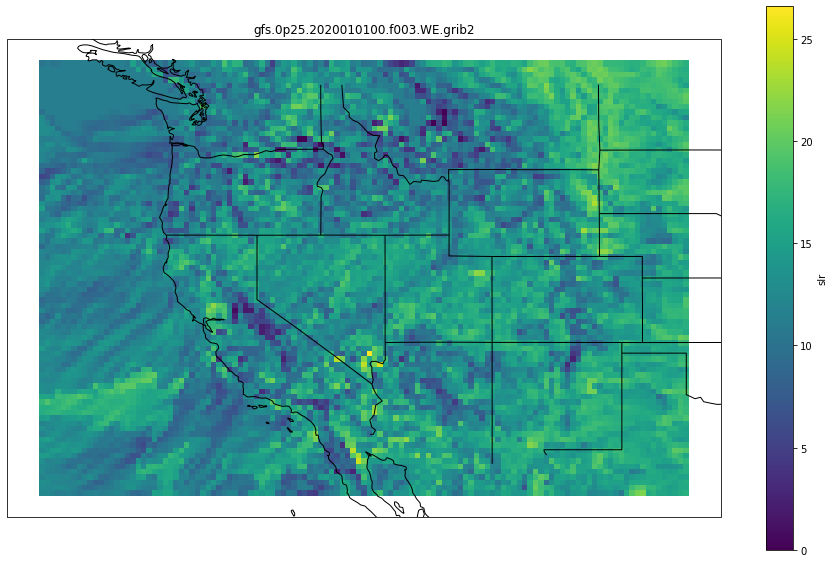

,count,mean,std,min,25%,50%,75%,max
slr,9801.0,13.183784,3.379921,0.0,10.974493,13.132646,15.691812,26.588879


In [65]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

slr.plot.pcolormesh(ax=ax)

ax.coastlines()

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='110m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='k')

plt.title(os.path.basename(flist[1]))
plt.show()
slr.to_dataframe().describe().T